In [6]:
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix, classification_report
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

# Original Dataset

In [7]:
# Load the data
df = pd.read_csv('../../data/processed/heart_se.csv')
# Split the data into features and target variable
X = df.drop(['target','index'], axis=1)
y = df['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Define the objective function to be optimized
def objective(trial):
    # Suggest values for the hyperparameters
    C = trial.suggest_float('C', 0.1, 10.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    coef0 = trial.suggest_float('coef0', 0.0, 1.0)
    shrinking = trial.suggest_categorical('shrinking', [True, False])
    tol = trial.suggest_float('tol', 1e-5, 1e-2, log=True)
    cache_size = trial.suggest_float('cache_size', 100.0, 500.0)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    max_iter = trial.suggest_int('max_iter', 1000, 10000)
    decision_function_shape = trial.suggest_categorical('decision_function_shape', ['ovo', 'ovr'])
    
    # Only allow break_ties to be True if decision_function_shape is 'ovr'
    if decision_function_shape == 'ovr':
        break_ties = trial.suggest_categorical('break_ties', [True, False])
    else:
        break_ties = False

    # Create an SVM classifier with the suggested hyperparameters
    svm = SVC(
        C=C,
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        coef0=coef0,
        shrinking=shrinking,
        probability=False,  # Keeping probability as False for optimization
        tol=tol,
        cache_size=cache_size,
        class_weight=class_weight,
        verbose=False,  # Verbose mode off for optimization
        max_iter=max_iter,
        decision_function_shape=decision_function_shape,
        break_ties=break_ties,
        random_state=42
    )

    # Use cross-validation to evaluate the model
    score = cross_val_score(svm, X_train, y_train, n_jobs=-1, cv=3)
    accuracy = score.mean()

    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train the final model with the best hyperparameters
svm = SVC(**best_params)
svm.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = svm.predict(X_test)

# Evaluate the final model
accuracy = svm.score(X_test, y_test)
print(f"Test set accuracy: {accuracy:.2f}")

[I 2024-08-28 22:49:55,778] A new study created in memory with name: no-name-9938c551-f8e7-4183-9974-97f4a0d2eebd
[I 2024-08-28 22:49:55,794] Trial 0 finished with value: 0.8143004115226337 and parameters: {'C': 0.48626235547905305, 'kernel': 'sigmoid', 'gamma': 'scale', 'coef0': 0.9970430896606839, 'shrinking': False, 'tol': 0.0008024065968494452, 'cache_size': 244.67947659518342, 'class_weight': None, 'max_iter': 4201, 'decision_function_shape': 'ovr', 'break_ties': False}. Best is trial 0 with value: 0.8143004115226337.
[I 2024-08-28 22:49:55,810] Trial 1 finished with value: 0.8141975308641975 and parameters: {'C': 2.8639322131964553, 'kernel': 'rbf', 'gamma': 'auto', 'coef0': 0.19469684553132482, 'shrinking': True, 'tol': 2.6347155130053687e-05, 'cache_size': 130.32384464659953, 'class_weight': None, 'max_iter': 6753, 'decision_function_shape': 'ovr', 'break_ties': True}. Best is trial 0 with value: 0.8143004115226337.
[I 2024-08-28 22:49:55,825] Trial 2 finished with value: 0.793

Best hyperparameters: {'C': 1.9077419946572087, 'kernel': 'poly', 'degree': 5, 'gamma': 'auto', 'coef0': 0.4864963210800137, 'shrinking': False, 'tol': 0.0007805863416763437, 'cache_size': 489.7635779101125, 'class_weight': 'balanced', 'max_iter': 9820, 'decision_function_shape': 'ovr', 'break_ties': False}
Test set accuracy: 0.87


In [9]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# Plot the optimization history
opt_history = plot_optimization_history(study)
opt_history.show()


In [10]:
# Plot the hyperparameter importances
param_importance = plot_param_importances(study)
param_importance.show()

In [28]:
# Plot including all hyperparameters, even if some dominate
parallel_coordinate = plot_parallel_coordinate(study, params=study.best_params.keys())
parallel_coordinate.show()

In [12]:

# Plot the slice plot for each hyperparameter
slice_plot = plot_slice(study)
slice_plot.show()

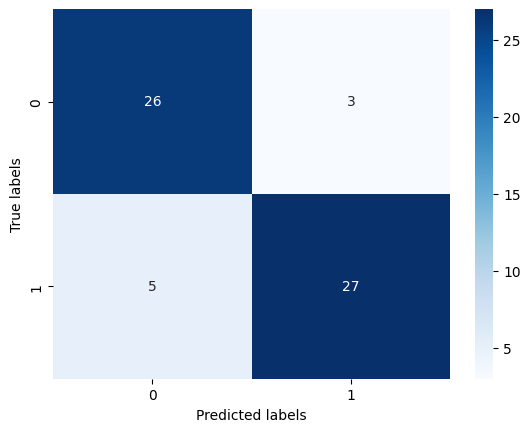

In [13]:
#test the model with the best hyperparameters
y_pred = svm.predict(X_test)
#plot the confusion matrix 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()



In [14]:
# Generate a classification report
cls_report = classification_report(y_test, y_pred)
print(cls_report)

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



# Rebalanced

In [15]:
# Load the data
df_train = pd.read_csv('../../data/processed/resampled/heart_resampled_train_se.csv')
df_test = pd.read_csv('../../data/processed/resampled/heart_resampled_test_se.csv')

# Split the data into features and target variable
X_train = df_train.drop(['target','index'], axis=1)
y_train = df_train['target']
X_test = df_test.drop(['target','index'], axis=1)
y_test = df_test['target']

In [16]:
# Define the objective function to be optimized
def objective(trial):
    # Suggest values for the hyperparameters
    C = trial.suggest_float('C', 0.1, 10.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    coef0 = trial.suggest_float('coef0', 0.0, 1.0)
    shrinking = trial.suggest_categorical('shrinking', [True, False])
    tol = trial.suggest_float('tol', 1e-5, 1e-2, log=True)
    cache_size = trial.suggest_float('cache_size', 100.0, 500.0)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    max_iter = trial.suggest_int('max_iter', 1000, 10000)
    decision_function_shape = trial.suggest_categorical('decision_function_shape', ['ovo', 'ovr'])
    
    # Only allow break_ties to be True if decision_function_shape is 'ovr'
    if decision_function_shape == 'ovr':
        break_ties = trial.suggest_categorical('break_ties', [True, False])
    else:
        break_ties = False

    # Create an SVM classifier with the suggested hyperparameters
    svm = SVC(
        C=C,
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        coef0=coef0,
        shrinking=shrinking,
        probability=False,  # Keeping probability as False for optimization
        tol=tol,
        cache_size=cache_size,
        class_weight=class_weight,
        verbose=False,  # Verbose mode off for optimization
        max_iter=max_iter,
        decision_function_shape=decision_function_shape,
        break_ties=break_ties,
        random_state=42
    )

    # Use cross-validation to evaluate the model
    score = cross_val_score(svm, X_train, y_train, n_jobs=-1, cv=3)
    accuracy = score.mean()

    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train the final model with the best hyperparameters
svm = SVC(**best_params)
svm.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = svm.predict(X_test)

# Evaluate the final model
accuracy = svm.score(X_test, y_test)
print(f"Test set accuracy: {accuracy:.2f}")

[I 2024-08-28 22:50:16,443] A new study created in memory with name: no-name-2bc3b746-5e73-4e6c-a214-2e36c7119eec
[I 2024-08-28 22:50:16,460] Trial 0 finished with value: 0.8475269940787182 and parameters: {'C': 0.11311588802142532, 'kernel': 'poly', 'degree': 3, 'gamma': 'scale', 'coef0': 0.3680475902463426, 'shrinking': True, 'tol': 1.6033433638048518e-05, 'cache_size': 260.04810349268956, 'class_weight': None, 'max_iter': 4967, 'decision_function_shape': 'ovo'}. Best is trial 0 with value: 0.8475269940787182.
[I 2024-08-28 22:50:16,476] Trial 1 finished with value: 0.8474399164054337 and parameters: {'C': 0.47772611577052093, 'kernel': 'linear', 'gamma': 'scale', 'coef0': 0.40363112313866767, 'shrinking': False, 'tol': 0.0008729691558497318, 'cache_size': 300.0260377169579, 'class_weight': 'balanced', 'max_iter': 8350, 'decision_function_shape': 'ovr', 'break_ties': False}. Best is trial 0 with value: 0.8475269940787182.
[I 2024-08-28 22:50:16,489] Trial 2 finished with value: 0.790

Best hyperparameters: {'C': 2.8460759553277644, 'kernel': 'sigmoid', 'gamma': 'auto', 'coef0': 0.23054590807915004, 'shrinking': False, 'tol': 0.00024417356894955086, 'cache_size': 113.63859250351568, 'class_weight': 'balanced', 'max_iter': 5191, 'decision_function_shape': 'ovo'}
Test set accuracy: 0.87


In [17]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# Plot the optimization history
opt_history = plot_optimization_history(study)
opt_history.show()


In [18]:
# Plot the hyperparameter importances
param_importance = plot_param_importances(study)
param_importance.show()

In [27]:
# Plot including all hyperparameters, even if some dominate
parallel_coordinate = plot_parallel_coordinate(study, params=study.best_params.keys())
parallel_coordinate.show()

In [20]:

# Plot the slice plot for each hyperparameter
slice_plot = plot_slice(study)
slice_plot.show()

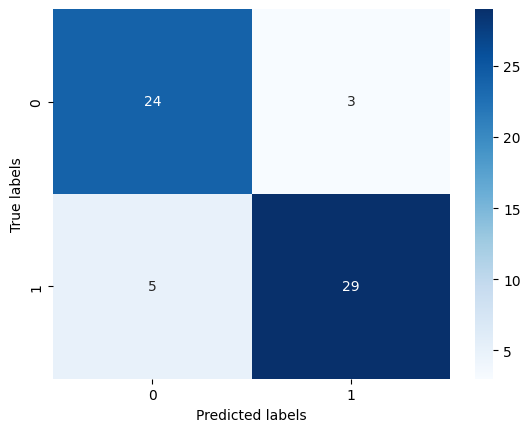

In [21]:
#test the model with the best hyperparameters
y_pred = svm.predict(X_test)
#plot the confusion matrix 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()



In [22]:
# Generate a classification report
cls_report = classification_report(y_test, y_pred)
print(cls_report)

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        27
           1       0.91      0.85      0.88        34

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



# Hand Model

In [66]:
svm  = SVC(C=0.1, kernel='rbf', degree=2)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

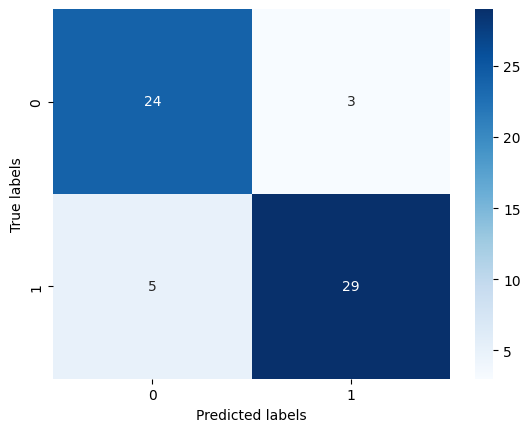

In [67]:
#plot the confusion matrix 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [68]:
# Generate a classification report
cls_report = classification_report(y_test, y_pred)
print(cls_report)

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        27
           1       0.91      0.85      0.88        34

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61

